## Imports

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 6.8 MB 49.6 MB/s 
     |████████████████████████████████| 895 kB 61.2 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os, re, torch, html, tempfile, copy, json, math, shutil, tarfile, tempfile, sys, random, pickle, string
from torch import nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss, ReLU, DataParallel
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import RobertaTokenizer, BertForTokenClassification, BertTokenizer, BertConfig, BertModel, WordpieceTokenizer, XLNetTokenizer, AutoTokenizer, get_linear_schedule_with_warmup
from transformers.file_utils import cached_path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import time
from copy import deepcopy
from sklearn.metrics import classification_report
import seaborn as sn

MAX_LENGTH = 0

## Preprocessing

In [ ]:
def load_bioscope_data():
        with open('bioscope.papers.columns.txt', 'r') as f, open('bioscope.papers.columns.txt_', 'w') as fo:
            for line in f:
                fo.write(line.replace('"', '').replace("'", ""))
        df_train_extra = pd.read_csv("bioscope.papers.columns.txt_" , names=["Text", "Sentence_N", "Word_N", "Word", "Label", "Scope", "/"], quotechar='"' , delimiter="\t", engine="python")
        df_train_extra.drop(["Scope", "/"], axis=1, inplace=True)
        df_train_extra["Label"].loc[(df_train_extra['Label'] == '_')] = 'O'
        df_train_extra["Label"].loc[(df_train_extra['Label'] == 'B-negation')] = 'B-NEG'
        df_train_extra["Label"].loc[(df_train_extra['Label'] == 'I-negation')] = 'I-NEG'
        df_train_extra["Text"] = df_train_extra["Text"].astype(str)
        df_train_extra["Word"] = df_train_extra["Word"].astype(str)
        df_train_extra["Label"] = df_train_extra["Label"].astype(str)
        df_train_extra = df_train_extra.dropna()

        return df_train_extra

def process_labels(label):
    if label == "O":
        return 0
    elif label=="B-NEG":
        return 1
    elif label == "I-NEG":
        return 2
    else:
        print(label)
        print("Error")
        return 0

# def undersampling(train_sents, train_labels):

#     new_sents = []
#     new_labels = []

#     for idx, sent in enumerate(train_sents):
#         labels = train_labels[idx]
        
#         if 2 in labels or 3 in labels:
#             new_sents.append(sent)
#             new_labels.append(labels)

#     print( "Number of sentences selected:", len(new_sents) )

#     return new_sents, new_labels

def tokenize_words(word):
    token_list = tokenizer.tokenize(word)
    return [ tokenizer.convert_tokens_to_ids(token) for token in token_list]

def tokenize_BERT(df, tokenizer):
    '''
    Tokenizes each word in the original data and expands the dataframe for each new token.

    :param df: the original dataframe
    :return: the updated dataframe
    '''

    df["Label"] = df["Label"].apply( lambda x: process_labels( x ) )

    df["Id"] = df["Text"]+ "_" +df["Sentence_N"].astype(str)

    df["Bert_token"] = df["Word"].apply( lambda x: tokenize_words(x) )
    df = df.explode("Bert_token").reset_index(drop=True)

    df = df[["Id", "Bert_token", "Label"]]
    grouped_df = df.groupby('Id').agg(lambda x: list(x)).reset_index()

    return grouped_df["Bert_token"].to_list(), grouped_df["Label"].to_list()


def add_padding_and_masks(sents, labels, maximum_length):

    sents = pad_sequences(sents, maxlen = maximum_length,  padding = "post", value = 3 )
    labels = pad_sequences(labels, maxlen = maximum_length,  padding = "post", value = 3 )

    masks = []

    for sent in sents:
        att_mask = [int(token_id > 0) for token_id in sent]
        masks.append( att_mask )

    return sents, labels, masks

def tokenize_df(df, tokenizer):

    sents, labels = tokenize_BERT(df, tokenizer)

    for idx,sent in enumerate(sents):
        sents[idx].insert(0,101)
        sents[idx].append( 102)

        labels[idx].extend( [0,0] )

    return sents,labels

def load_train_val_data(tokenizer):
    global MAX_LENGTH

    train_df = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt', \
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])
    
    bioscope_df = load_bioscope_data()

    train_df = pd.concat([train_df, bioscope_df]).reset_index(drop=True)

    dev_df = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt', \
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])
    
    df_test1 = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-test-circle.txt',
        names=['Text','Sentence_N','Word_N','Word', 'Label'] )
    
    df_test2 = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-test-cardboard.txt',
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])

    tests = [df_test1, df_test2]
    test_df = pd.concat(tests).reset_index(drop=True)

    train_sents, train_labels = tokenize_df(train_df, tokenizer)
    dev_sents, dev_labels = tokenize_df(dev_df, tokenizer)
    test_sents, test_labels = tokenize_df(test_df, tokenizer)

    max_length = max( max( [ len(x) for x in train_sents ] ), max( [ len(x) for x in dev_sents ] ), max( [ len(x) for x in test_sents ] ) )
    MAX_LENGTH = deepcopy(max_length)

    train_sents, train_labels, train_masks = add_padding_and_masks(train_sents, train_labels, max_length)
    dev_sents, dev_labels, dev_masks = add_padding_and_masks(dev_sents, dev_labels, max_length)
    test_sents, test_labels, test_masks = add_padding_and_masks(test_sents, test_labels, max_length)


    return train_sents, train_masks, train_labels, dev_sents, dev_masks, dev_labels, test_sents, test_masks, test_labels
    


In [ ]:
## THIS IS ONLY USED FOR TESTING
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# train_sents, train_masks, train_labels, dev_sents, dev_masks, dev_labels,test_sents, test_masks, test_labels  = load_train_val_data(tokenizer)

# print(train_sents[0])
# print(train_masks[0])
# print(train_labels[0])


## Loading Model

### Loading train-test data

In [ ]:
config_class, model_class, tokenizer_class = (BertConfig, BertForTokenClassification, BertTokenizer)
# model_dir = "neg_cue_bert/"
#tokenizer = tokenizer_class.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_sents, train_masks, train_labels, dev_sents, dev_masks, dev_labels, test_sents, test_masks, test_labels  = load_train_val_data(tokenizer)

train_inputs = torch.tensor(train_sents, dtype = torch.long)
validation_inputs = torch.tensor(dev_sents, dtype = torch.long)
test_inputs = torch.tensor(test_sents, dtype = torch.long)

# Labels
train_labels = torch.tensor(train_labels, dtype = torch.long)
validation_labels = torch.tensor(dev_labels, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)

# Attention masks
train_masks = torch.tensor(train_masks, dtype = torch.long)
validation_masks = torch.tensor(dev_masks, dtype = torch.long)
test_masks = torch.tensor(test_masks)

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle = True)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle = True)


# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = False)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Load model to cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### IGNORE THE WARNING MESSAGE, it was always like this, but now it just prints the message for clarifications

model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=4) #includes padding for labels

model = DataParallel(model)

# Set the model to work on CPU if no GPU is present
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

DataParallel(
  (module): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)


### Loading Optimiser and Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                )

epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=total_steps / 100,  # Default value in run_glue.py
                                            num_training_steps=total_steps)


## Training, Validating and Testing BERT

### Training function per epoch



In [ ]:
def train_fn(data_loader, model, optimizer, scheduler):
    
    train_loss = 0
    for index, dataset in enumerate(tqdm(data_loader)):
        batch_input_ids = dataset[0].to(device, dtype = torch.long)
        batch_att_mask = dataset[1].to(device, dtype = torch.long)
        batch_target = dataset[2].to(device, dtype = torch.long)
                
        output = model(batch_input_ids, 
                       token_type_ids=None,
                       attention_mask=batch_att_mask,
                       labels=batch_target)
        
        step_loss = output[0]
        prediction = output[1]
        
        step_loss.sum().backward()
        optimizer.step()
        scheduler.step()        
        train_loss += step_loss
        optimizer.zero_grad()
        
    return train_loss.sum()

### Evaluation function per epoch

In [ ]:
def eval_fn(data_loader, model):
    '''
    Functiont to evaluate the model on each epoch. 
    We can also use Jaccard metric to see the performance on each epoch.
    '''
    
    model.eval()
    
    eval_loss = 0
    predictions = np.array([], dtype = np.int64).reshape(0, MAX_LENGTH)
    true_labels = np.array([], dtype = np.int64).reshape(0, MAX_LENGTH)
    
    with torch.no_grad():
        for index, dataset in enumerate(tqdm(data_loader, total = len(data_loader))):
            batch_input_ids = dataset[0].to(device, dtype = torch.long)
            batch_att_mask = dataset[1].to(device, dtype = torch.long)
            batch_target = dataset[2].to(device, dtype = torch.long)

            output = model(batch_input_ids, 
                           token_type_ids=None,
                           attention_mask=batch_att_mask,
                           labels=batch_target)

            step_loss = output[0]
            eval_prediction = output[1]

            eval_loss += step_loss
            
            eval_prediction = np.argmax(eval_prediction.detach().to('cpu').numpy(), axis = 2)
            actual = batch_target.to('cpu').numpy()
            
            predictions = np.concatenate((predictions, eval_prediction), axis = 0)
            true_labels = np.concatenate((true_labels, actual), axis = 0)
            
    return eval_loss.sum(), predictions, true_labels

### Test Function per epoch

In [ ]:
def test_fn(data_loader, model):
    '''
    Functiont to evaluate the model on each epoch. 
    We can also use Jaccard metric to see the performance on each epoch.
    '''
    
    model.eval()
    
    eval_loss = 0
    predictions = np.array([], dtype = np.int64).reshape(0, MAX_LENGTH)
    true_labels = np.array([], dtype = np.int64).reshape(0, MAX_LENGTH)
    
    with torch.no_grad():
        for index, dataset in enumerate(tqdm(data_loader, total = len(data_loader))):
            batch_input_ids = dataset[0].to(device, dtype = torch.long)
            batch_att_mask = dataset[1].to(device, dtype = torch.long)
            batch_target = dataset[2].to(device, dtype = torch.long)

            output = model(batch_input_ids, 
                           token_type_ids=None,
                           attention_mask=batch_att_mask,
                           labels=batch_target)

            step_loss = output[0]
            eval_prediction = output[1]

            eval_loss += step_loss
            
            eval_prediction = np.argmax(eval_prediction.detach().to('cpu').numpy(), axis = 2)
            actual = batch_target.to('cpu').numpy()
            
            predictions = np.concatenate((predictions, eval_prediction), axis = 0)
            true_labels = np.concatenate((true_labels, actual), axis = 0)
            
    return eval_loss.sum(), predictions, true_labels

### Overview Train and Validation functions

In [ ]:
best_eval_loss = 1000000
for i in range(epochs):
    train_loss = train_fn(data_loader = train_dataloader, 
                            model=model, 
                            optimizer=optimizer,
                            scheduler = scheduler)
    
    eval_loss, eval_predictions, true_labels = eval_fn(data_loader = validation_dataloader, 
                                                        model=model)
    
    print(f"Epoch {i} , Train loss: {train_loss}, Eval loss: {eval_loss}")

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss           
        
        print("Saving the model")
        torch.save(model.state_dict(), "Bert-base-uncased_neg")

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 , Train loss: 27.394962310791016, Eval loss: 0.27180153131484985
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 , Train loss: 1.5963293313980103, Eval loss: 0.15723109245300293
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 , Train loss: 0.8025734424591064, Eval loss: 0.0879008024930954
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 , Train loss: 0.4797031283378601, Eval loss: 0.06385457515716553
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 , Train loss: 0.3185677230358124, Eval loss: 0.06336917728185654
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 , Train loss: 0.22543543577194214, Eval loss: 0.05519535019993782
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 , Train loss: 0.1650467813014984, Eval loss: 0.05433912202715874
Saving the model


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 , Train loss: 0.12472230195999146, Eval loss: 0.05524018406867981


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 , Train loss: 0.09913012385368347, Eval loss: 0.05733929201960564


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 , Train loss: 0.08515584468841553, Eval loss: 0.05560850724577904


### Test classification Report

In [ ]:
test_loss, test_predictions, true_test_labels = test_fn(data_loader = test_dataloader, model=model)
clsf_report = pd.DataFrame(classification_report(y_true = true_test_labels.flatten(), y_pred = test_predictions.flatten(), output_dict = True)).transpose()
clsf_report

  0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.997259,0.998823,0.998040,22945.000000
1,0.918129,0.841823,0.878322,373.000000
2,0.000000,0.000000,0.000000,5.000000
3,1.000000,1.000000,1.000000,309911.000000
accuracy,0.999727,0.999727,0.999727,0.999727
macro avg,0.728847,0.710162,0.719091,333234.000000
weighted avg,0.999705,0.999727,0.999714,333234.000000


In [ ]:
np.savetxt("true_labels.csv", true_test_labels.flatten(), delimiter = ";")
np.savetxt("test_predictions.csv", test_predictions.flatten(), delimiter = ";")

In [ ]:
def revert_labels(label):
    if label == 0:
        return "O"
    elif label==1:
        return "B-NEG"
    elif label == 2:
        return "I-NEG"
    elif label == 3:
        return "Padding"
    else:
        print(label)
        print("Error")
        return 0

predicted_labels = pd.read_csv("test_predictions.csv", header = None, delimiter = ";", dtype = "Int64")
predicted_labels = predicted_labels.iloc[:,0].tolist()
print(predicted_labels[0:3])
print(len(predicted_labels))
true_labels = list(test_labels.numpy().flatten())
print(true_labels[0:3])
print(len(true_labels))
conf_df = pd.DataFrame(list(zip(true_labels, predicted_labels)), columns = ['Label', "Predictions"])

conf_df["Label"] = conf_df["Label"].apply(lambda x: revert_labels(x))
conf_df["Predictions"] = conf_df["Predictions"].apply(lambda x: revert_labels(x))

conf_df.head(20)



[0, 0, 0]
333234
[0, 0, 0]
333234


,Label,Predictions
0,O,O
1,O,O
2,O,O
3,O,O
4,O,O
5,O,O
6,O,O
7,O,O
8,O,O
9,O,O


Predicted  B-NEG      O  Padding
Actual                          
B-NEG        314     59        0
I-NEG          1      4        0
O             27  22918        0
Padding        0      0   309911


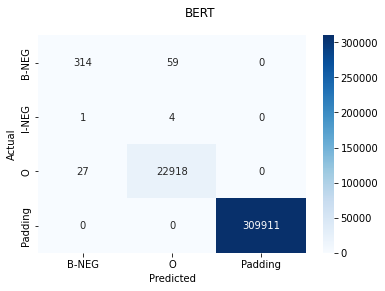

In [ ]:
names_p = ["Predicted", "B-NEG", "I-NEG", "O"]
names_a = ["Actual", "B-NEG", "I-NEG", "O"]
confusion_matrix = pd.crosstab(conf_df['Label'], conf_df['Predictions'], rownames=['Actual'], colnames = ['Predicted'], dropna = False)
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels = True, yticklabels = True)
plt.suptitle('BERT')
#plt.show()
plt.savefig('BERT.pdf')